['deflection_spec forward', 'z-axis sensor_spec forward', 'deflection_spec backward', 'z-axis sensor_spec backward', 'tip-sample separation_indentationzsensorfwd0', 'tip-sample separation_indentationzsensorbwd0', 'deflection_indentationdeflfwd0', 'deflection_indentationdeflbwd0', 'namez4_slopeout00', 'namez5_slopeout10', 'namez6_slopeout20', 'namez7_maxadhesionout00', 'namez8_maxadhesionout10', 'namez9_slopeout01', 'namez10_slopeout11', 'namez11_slopeout21', 'namez12_snapinout00', 'namez13_snapinout10', 'deflection_scan forward', 'z-axis_scan forward', 'z-axis sensor_scan forward', 'deflection_scan backward', 'z-axis_scan backward', 'z-axis sensor_scan backward']
['DataSet', 'DataSet-Info', 'DataSet\\DataSetInfos', 'DataSet\\DataSetInfos\\Spec', 'DataSet\\DataSetInfos\\Scan', 'DataSet\\DataSetInfos\\Feedback', 'DataSet\\DataSetInfos\\Module', 'DataSet\\DataSetInfos\\Global', 'DataSet\\Calibration', 'DataSet\\Calibration\\Scanhead', 'DataSet\\Calibration\\Cantilever', 'DataSet\\Paramete

Text(0, 0.5, 'Deflection (nm)')

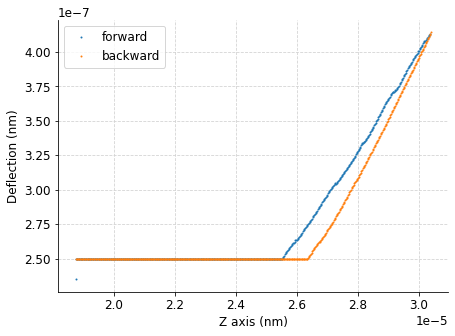

In [3]:
#%%
from pathlib import Path
import mmap
from configparser import ConfigParser, SectionProxy
import re

import numpy as np


def get_dataset_sections(config: ConfigParser):
    section_regex = re.compile("DataSet-\d+:\d+")
    return filter(
        lambda name: re.match(section_regex, name) is not None, config.sections()
    )


def get_dtype(config: ConfigParser, name: str) -> np.dtype:
    section = config[name]
    assert (
        section["SaveMode"] == "Binary"
    ), "Reading non-binary data format is not supported!"
    endian = "<" if section["SaveOrder"] == "Intel" else ">"
    data_format = "i" if section["SaveSign"] == "Signed" else "u"
    num_bytes = int(section["SaveBits"]) // 8
    return np.dtype(f"{endian}{data_format}{num_bytes}")


def get_read_shape(config: ConfigParser, name: str) -> tuple[int, int]:
    section = config[name]
    dim0, dim1 = section["Points"], section["Lines"]
    return (int(dim0), int(dim1))


def get_scale_params(config: ConfigParser, name: str) -> tuple[float, float]:
    section = config[name]
    range_, offset = section["Dim2Range"], section["Dim2Min"]
    return float(range_), float(offset)


def get_read_length(shape: tuple[int, int], dtype: np.dtype) -> int:
    return shape[0] * shape[1] * dtype.itemsize


def scale_data(data: np.ndarray, datarange: float, dataoffset: float) -> np.ndarray:
    min_val = np.iinfo(data.dtype).min
    normalized_data = 1.0 + data / np.abs(min_val)
    return normalized_data * datarange + dataoffset


def get_data_name(config: ConfigParser, name: str) -> str:
    section = config[name]
    name, frame = section["Dim2Name"], section["Frame"]
    return f"{name.lower()}_{frame.lower()}"


def read_nid(filepath: str | Path):
    config_parser = ConfigParser(allow_no_value=True)
    with open(filepath, "rb") as file:
        with mmap.mmap(file.fileno(), length=0, access=mmap.ACCESS_READ) as memorymap:
            data_start_ind = memorymap.find(b"#!")
            header = memorymap[:data_start_ind].decode()
            config_list = header.split("\r\n")
            config_parser.read_file(config_list)

            shapes = [
                get_read_shape(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            dtypes = [
                get_dtype(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            read_lengths = [get_read_length(s, d) for s, d in zip(shapes, dtypes)]

            memorymap.seek(data_start_ind + 2)
            raw_data = [
                np.frombuffer(memorymap.read(n), d)
                for n, d in zip(read_lengths, dtypes)
            ]
            scale_params = [
                get_scale_params(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            data = [
                scale_data(raw, *p).reshape(s)
                for raw, p, s in zip(raw_data, scale_params, shapes)
            ]
            names = [
                get_data_name(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]

    return config_parser, dict(zip(names, data))


#%%
file = "../../data/afm/20230106/regular hydrogel/Image00822.nid"
config, data = read_nid(file)
print(list(data.keys()))
print(list(config.sections()))
#%%
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font", size=12)
matplotlib.rc("axes", grid=True)
matplotlib.rc("axes.spines", top=False, right=False)
matplotlib.rc("grid", linestyle="--", color="lightgray")


fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
for mode in ("forward", "backward"):
    ax.plot(
        data[f"z-axis sensor_spec {mode}"],
        data[f"deflection_spec {mode}"],
        ".",
        markersize=2,
        label=mode,
    )
ax.legend()
ax.set_xlabel("Z axis (nm)")
ax.set_ylabel("Deflection (nm)")

['deflection_spec forward', 'z-axis sensor_spec forward', 'deflection_spec backward', 'z-axis sensor_spec backward', 'tip-sample separation_indentationzsensorfwd0', 'tip-sample separation_indentationzsensorbwd0', 'deflection_indentationdeflfwd0', 'deflection_indentationdeflbwd0', 'namez4_slopeout00', 'namez5_slopeout10', 'namez6_slopeout20', 'namez7_maxadhesionout00', 'namez8_maxadhesionout10', 'namez9_slopeout01', 'namez10_slopeout11', 'namez11_slopeout21', 'namez12_snapinout00', 'namez13_snapinout10', 'deflection_scan forward', 'z-axis_scan forward', 'z-axis sensor_scan forward', 'deflection_scan backward', 'z-axis_scan backward', 'z-axis sensor_scan backward']
['DataSet', 'DataSet-Info', 'DataSet\\DataSetInfos', 'DataSet\\DataSetInfos\\Spec', 'DataSet\\DataSetInfos\\Scan', 'DataSet\\DataSetInfos\\Feedback', 'DataSet\\DataSetInfos\\Module', 'DataSet\\DataSetInfos\\Global', 'DataSet\\Calibration', 'DataSet\\Calibration\\Scanhead', 'DataSet\\Calibration\\Cantilever', 'DataSet\\Paramete

Text(0, 0.5, 'Deflection (nm)')

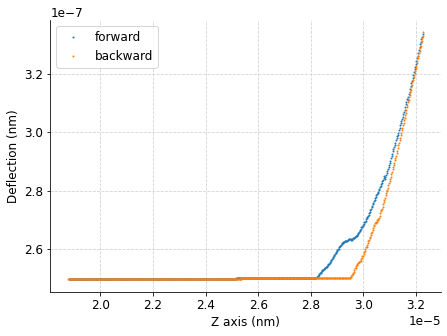

In [10]:
#%%
from pathlib import Path
import mmap
from configparser import ConfigParser, SectionProxy
import re

import numpy as np


def get_dataset_sections(config: ConfigParser):
    section_regex = re.compile("DataSet-\d+:\d+")
    return filter(
        lambda name: re.match(section_regex, name) is not None, config.sections()
    )


def get_dtype(config: ConfigParser, name: str) -> np.dtype:
    section = config[name]
    assert (
        section["SaveMode"] == "Binary"
    ), "Reading non-binary data format is not supported!"
    endian = "<" if section["SaveOrder"] == "Intel" else ">"
    data_format = "i" if section["SaveSign"] == "Signed" else "u"
    num_bytes = int(section["SaveBits"]) // 8
    return np.dtype(f"{endian}{data_format}{num_bytes}")


def get_read_shape(config: ConfigParser, name: str) -> tuple[int, int]:
    section = config[name]
    dim0, dim1 = section["Points"], section["Lines"]
    return (int(dim0), int(dim1))


def get_scale_params(config: ConfigParser, name: str) -> tuple[float, float]:
    section = config[name]
    range_, offset = section["Dim2Range"], section["Dim2Min"]
    return float(range_), float(offset)


def get_read_length(shape: tuple[int, int], dtype: np.dtype) -> int:
    return shape[0] * shape[1] * dtype.itemsize


def scale_data(data: np.ndarray, datarange: float, dataoffset: float) -> np.ndarray:
    min_val = np.iinfo(data.dtype).min
    normalized_data = 1.0 + data / np.abs(min_val)
    return normalized_data * datarange + dataoffset


def get_data_name(config: ConfigParser, name: str) -> str:
    section = config[name]
    name, frame = section["Dim2Name"], section["Frame"]
    return f"{name.lower()}_{frame.lower()}"


def read_nid(filepath: str | Path):
    config_parser = ConfigParser(allow_no_value=True)
    with open(filepath, "rb") as file:
        with mmap.mmap(file.fileno(), length=0, access=mmap.ACCESS_READ) as memorymap:
            data_start_ind = memorymap.find(b"#!")
            header = memorymap[:data_start_ind].decode()
            config_list = header.split("\r\n")
            config_parser.read_file(config_list)

            shapes = [
                get_read_shape(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            dtypes = [
                get_dtype(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            read_lengths = [get_read_length(s, d) for s, d in zip(shapes, dtypes)]

            memorymap.seek(data_start_ind + 2)
            raw_data = [
                np.frombuffer(memorymap.read(n), d)
                for n, d in zip(read_lengths, dtypes)
            ]
            scale_params = [
                get_scale_params(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            data = [
                scale_data(raw, *p).reshape(s)
                for raw, p, s in zip(raw_data, scale_params, shapes)
            ]
            names = [
                get_data_name(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]

    return config_parser, dict(zip(names, data))


#%%
file = "./Image00820.nid"
config, data = read_nid(file)
print(list(data.keys()))
print(list(config.sections()))
#%%
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font", size=12)
matplotlib.rc("axes", grid=True)
matplotlib.rc("axes.spines", top=False, right=False)
matplotlib.rc("grid", linestyle="--", color="lightgray")


fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
for mode in ("forward", "backward"):
    ax.plot(
        data[f"z-axis sensor_spec {mode}"],
        data[f"deflection_spec {mode}"],
        ".",
        markersize=2,
        label=mode,
    )
ax.legend()
ax.set_xlabel("Z axis (nm)")
ax.set_ylabel("Deflection (nm)")

['deflection_spec forward', 'z-axis sensor_spec forward', 'deflection_spec backward', 'z-axis sensor_spec backward', 'tip-sample separation_indentationzsensorfwd0', 'tip-sample separation_indentationzsensorbwd0', 'deflection_indentationdeflfwd0', 'deflection_indentationdeflbwd0', 'namez4_slopeout00', 'namez5_slopeout10', 'namez6_slopeout20', 'namez7_maxadhesionout00', 'namez8_maxadhesionout10', 'namez9_slopeout01', 'namez10_slopeout11', 'namez11_slopeout21', 'namez12_snapinout00', 'namez13_snapinout10', 'deflection_scan forward', 'z-axis_scan forward', 'z-axis sensor_scan forward', 'deflection_scan backward', 'z-axis_scan backward', 'z-axis sensor_scan backward']
['DataSet', 'DataSet-Info', 'DataSet\\DataSetInfos', 'DataSet\\DataSetInfos\\Spec', 'DataSet\\DataSetInfos\\Scan', 'DataSet\\DataSetInfos\\Feedback', 'DataSet\\DataSetInfos\\Module', 'DataSet\\DataSetInfos\\Global', 'DataSet\\Calibration', 'DataSet\\Calibration\\Scanhead', 'DataSet\\Calibration\\Cantilever', 'DataSet\\Paramete

Text(0, 0.5, 'Deflection (nm)')

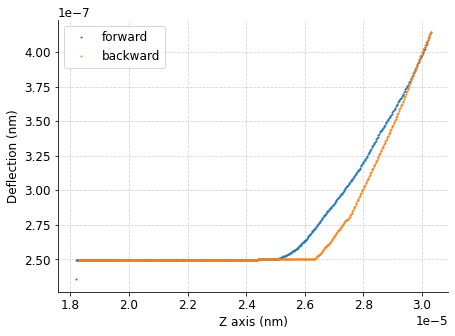

In [7]:
#%%
from pathlib import Path
import mmap
from configparser import ConfigParser, SectionProxy
import re

import numpy as np


def get_dataset_sections(config: ConfigParser):
    section_regex = re.compile("DataSet-\d+:\d+")
    return filter(
        lambda name: re.match(section_regex, name) is not None, config.sections()
    )


def get_dtype(config: ConfigParser, name: str) -> np.dtype:
    section = config[name]
    assert (
        section["SaveMode"] == "Binary"
    ), "Reading non-binary data format is not supported!"
    endian = "<" if section["SaveOrder"] == "Intel" else ">"
    data_format = "i" if section["SaveSign"] == "Signed" else "u"
    num_bytes = int(section["SaveBits"]) // 8
    return np.dtype(f"{endian}{data_format}{num_bytes}")


def get_read_shape(config: ConfigParser, name: str) -> tuple[int, int]:
    section = config[name]
    dim0, dim1 = section["Points"], section["Lines"]
    return (int(dim0), int(dim1))


def get_scale_params(config: ConfigParser, name: str) -> tuple[float, float]:
    section = config[name]
    range_, offset = section["Dim2Range"], section["Dim2Min"]
    return float(range_), float(offset)


def get_read_length(shape: tuple[int, int], dtype: np.dtype) -> int:
    return shape[0] * shape[1] * dtype.itemsize


def scale_data(data: np.ndarray, datarange: float, dataoffset: float) -> np.ndarray:
    min_val = np.iinfo(data.dtype).min
    normalized_data = 1.0 + data / np.abs(min_val)
    return normalized_data * datarange + dataoffset


def get_data_name(config: ConfigParser, name: str) -> str:
    section = config[name]
    name, frame = section["Dim2Name"], section["Frame"]
    return f"{name.lower()}_{frame.lower()}"


def read_nid(filepath: str | Path):
    config_parser = ConfigParser(allow_no_value=True)
    with open(filepath, "rb") as file:
        with mmap.mmap(file.fileno(), length=0, access=mmap.ACCESS_READ) as memorymap:
            data_start_ind = memorymap.find(b"#!")
            header = memorymap[:data_start_ind].decode()
            config_list = header.split("\r\n")
            config_parser.read_file(config_list)

            shapes = [
                get_read_shape(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            dtypes = [
                get_dtype(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            read_lengths = [get_read_length(s, d) for s, d in zip(shapes, dtypes)]

            memorymap.seek(data_start_ind + 2)
            raw_data = [
                np.frombuffer(memorymap.read(n), d)
                for n, d in zip(read_lengths, dtypes)
            ]
            scale_params = [
                get_scale_params(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]
            data = [
                scale_data(raw, *p).reshape(s)
                for raw, p, s in zip(raw_data, scale_params, shapes)
            ]
            names = [
                get_data_name(config_parser, name)
                for name in get_dataset_sections(config_parser)
            ]

    return config_parser, dict(zip(names, data))


#%%
file = "./Image00815.nid"
config, data = read_nid(file)
print(list(data.keys()))
print(list(config.sections()))
#%%
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rc("font", size=12)
matplotlib.rc("axes", grid=True)
matplotlib.rc("axes.spines", top=False, right=False)
matplotlib.rc("grid", linestyle="--", color="lightgray")


fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
for mode in ("forward", "backward"):
    ax.plot(
        data[f"z-axis sensor_spec {mode}"],
        data[f"deflection_spec {mode}"],
        ".",
        markersize=2,
        label=mode,
    )
ax.legend()
ax.set_xlabel("Z axis (nm)")
ax.set_ylabel("Deflection (nm)")

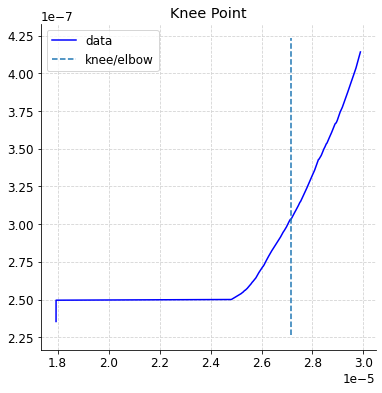

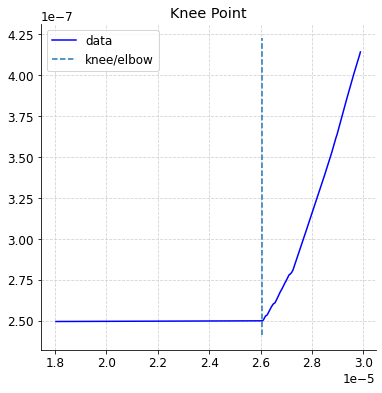

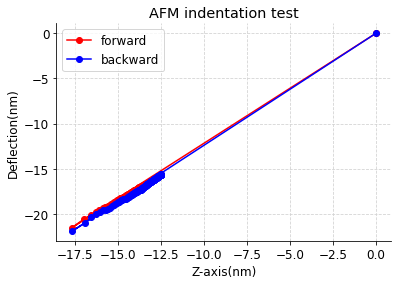

1.092517823571203 -2.0700246508992204 1.250777872080718 0.015370123169075286


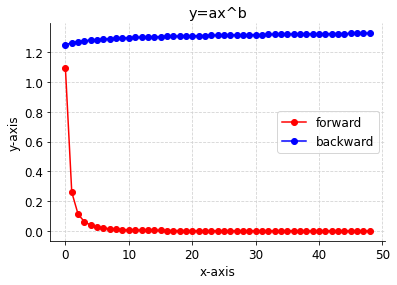

In [23]:
# Hertzian Curve Fitting
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator, DataGenerator as dg

zf = data["z-axis sensor_spec forward"].reshape(-1)
df = data["deflection_spec forward"].reshape(-1)
zb = data["z-axis sensor_spec backward"].reshape(-1)
db = data["deflection_spec backward"].reshape(-1)

# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating
zf = zf - df
zb = zb - db

# Find the kneepoint 
klf = KneeLocator(zf,df, curve="convex")
klb = KneeLocator(zb, db, curve="convex")
klf.plot_knee()
klb.plot_knee()
kpf = klf.knee
kpb = klb.knee

# Move to origin
num_zf = len(zf)
num_zb = len(zb)

zf = np.delete(zf, np.where(zf<kpf))
zb = np.delete(zb, np.where(zb<kpb))
df = np.delete(df, np.where(df<df[num_zf-len(zf)-1]))
db = np.delete(db, np.where(db<db[num_zb-len(zb)]))

lf = len(zf)
lb = len(zb)

for i in range(1,lf):
    zf[i] = np.log(zf[i] - zf[0])
    df[i] = np.log(df[i] - df[0])

for i in range(1,lb):
    zb[i] = np.log(zb[i] - zb[0])
    db[i] = np.log(db[i] - db[0])

fig, ax = plt.subplots(1, 1)   

ax.plot(zf, df, "o-", color = "red", label = 'forward')
ax.plot(zb, db, "o-", color = "blue", label = 'backward')
ax.set_xlabel('Z-axis(nm)')
ax.set_ylabel('Deflection(nm)')
ax.set_title('AFM indentation test')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()

# least square fitting
a11 = 0
a12 = 0
b1 = 0
b2 = 0

for i in range(1,lf):
    a11 += zf[i]*zf[i]
    a12 += zf[i]
    b1 += zf[i]*df[i]
    b2 += df[i]

a21 = a12
a22 = lf -1

af = (a22*b1-a12*b2)/(a11*a22-a12*a21)
bf = (a11*b2-a21*b1)/(a11*a22-a12*a21)

for i in range(1,lb):
    a11 += zb[i]*zb[i]
    a12 += zb[i]
    b1 += zb[i]*db[i]
    b2 += db[i]
a21 = a12
a22 = lb -1

ab = (a22*b1-a12*b2)/(a11*a22-a12*a21)
bb = (a11*b2-a21*b1)/(a11*a22-a12*a21)

print(af, bf, ab, bb)

x = range(1,50)
yf = af*pow(x,bf)
yb = ab*pow(x,bb)

fig, ax = plt.subplots(1, 1)   

ax.plot(yf, "o-", color = "red", label = 'forward')
ax.plot(yb, "o-", color = "blue", label = 'backward')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('y=ax^b')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()

/var/folders/6z/z725jdx950xdng1rd1h1qxq40000gn/T/ipykernel_91205/2617418948.py:45: RuntimeWarning: invalid value encountered in log
  deflection[i] = np.log(deflection[i] - deflection[0])
/var/folders/6z/z725jdx950xdng1rd1h1qxq40000gn/T/ipykernel_91205/2617418948.py:44: RuntimeWarning: invalid value encountered in log
  z_sensor[i] = np.log(z_sensor[i] - z_sensor[0])


ValueError: x and y must have same first dimension, but have shapes (127,) and (128,)

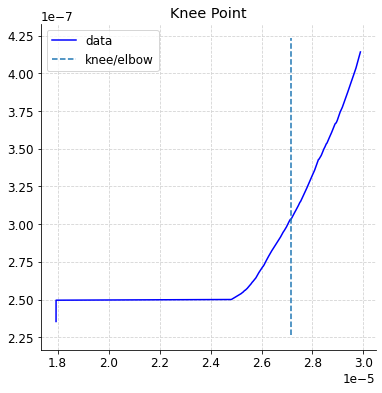

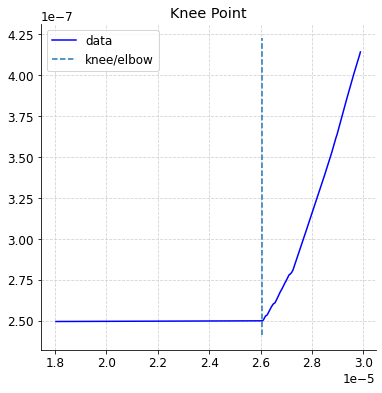

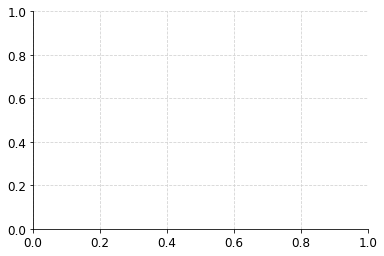

In [12]:
# Hertzian Curve Fitting(modified)
import numpy as np
import matplotlib.pyplot as plt
from kneed import KneeLocator, DataGenerator as dg

zf = data["z-axis sensor_spec forward"].reshape(-1)
df = data["deflection_spec forward"].reshape(-1)
zb = data["z-axis sensor_spec backward"].reshape(-1)
db = data["deflection_spec backward"].reshape(-1)

z_dict = {"f": zf, "b": zb}
d_dict = {"f": df, "b": db}

# Change the Z-axis sensor -> Z-axis sensor - Raw deflection / Broadcating
def z_sensor_to_tip_position(z_sensor: np.ndarray, deflection: np.ndarray)-> np.ndarray:
    if len(z_sensor) == len(deflection):
        z_sensor = z_sensor - deflection
    return z_sensor
    
z_dict = {k : z_sensor_to_tip_position(z_dict[k], d_dict[k]) for k in ("f", "b")}

# Find the kneepoint 
def find_kneepoint(z_sensor: np.ndarray, deflection: np.ndarray):
    kl = KneeLocator(z_sensor, deflection, curve="convex")
    kl.plot_knee()
    num = len(z_sensor)
    z_sensor = np.delete(z_sensor, np.where(z_sensor<kl.knee))
    deflection = np.delete(deflection, np.where(deflection<[deflection[num-len(z_sensor)]]))
    return [z_sensor, deflection]

a = {}
b = {}
for i in ("f", "b"):
    a = {i : find_kneepoint(z_dict[i],d_dict[i])}
    b.update(a)

z_dict = {k: b[k][0] for k in ("f", "b")}
d_dict = {k: b[k][1] for k in ("f", "b")}

# Move to origin
def move_to_origin(z_sensor:np.ndarray, deflection:np.ndarray):
    ln = len(z_sensor)
    for i in range(1,ln):
        z_sensor[i] = np.log(z_sensor[i] - z_sensor[0])
        deflection[i] = np.log(deflection[i] - deflection[0])
    return [z_sensor, deflection]

z_dict = {k : move_to_origin(z_dict[k],d_dict[k])[0] for k in ("f","b")}
d_dict = {k : move_to_origin(z_dict[k],d_dict[k])[1] for k in ("f","b")}

directions = ["f", "b"]
names = ["forward", "backward"]
colors = ["red", "blue"]

fig, ax = plt.subplots(1, 1)   

for d, n, c in zip(directions, names, colors):
    ax.plot(z_dict[d], d_dict[d], "o-", color = c, label = n)
    ax.set_xlabel('Z-axis(nm)')
    ax.set_ylabel('Deflection(nm)')
    ax.set_title('AFM indentation test')
    ax.grid(ls = "--", color = "lightgray")
    ax.legend()
    plt.show()

# least square fitting
def linear_fitting(z_sensor, deflection) :
    a11 = 0
    a12 = 0
    b1 = 0
    b2 = 0
    len = len(z_sensor)
    for i in range(1,len):
        a11 += zf[i]*zf[i]
        a12 += zf[i]
        b1 += zf[i]*df[i]
        b2 += df[i]

    a21 = a12
    a22 = len -1
    a = (a22*b1-a12*b2)/(a11*a22-a12*a21)
    b = (a11*b2-a21*b1)/(a11*a22-a12*a21)
    return a, b

x = range(1,50)
yf = af*pow(x,bf)
yb = ab*pow(x,bb)

fig, ax = plt.subplots(1, 1)   

ax.plot(yf, "o-", color = "red", label = 'forward')
ax.plot(yb, "o-", color = "blue", label = 'backward')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_title('y=ax^b')
ax.grid(ls = "--", color = "lightgray")
ax.legend()

plt.show()